In [ ]:
#@title Download data
import os
import requests
import tarfile
from concurrent.futures import ThreadPoolExecutor
import shutil
import tarfile
from pathlib import Path
try:
    import torchmetrics
except Exception as e:
    !pip install -q torchmetrics
    import torchmetrics
def download_file(url, folder):
    file_name = url.split("/")[-1]
    file_path = os.path.join(folder, file_name)

    if not os.path.exists(file_path):
        print(f"Downloading {url}")
        response = requests.get(url, stream=True)
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Download complete: {file_name}")
    else:
        print(f"File already exists: {file_name}")

def decompress_file(file_path, extract_folder):
    print(f"Decompressing {file_path}")
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_folder)
    print(f"Decompression complete")

def main():
    download_url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
    target_folder = "data"

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    download_file(download_url, target_folder)

    compressed_file_name = download_url.split("/")[-1]
    compressed_file_path = os.path.join(target_folder, compressed_file_name)
    extraction_folder = os.path.join(target_folder, "food-101")

    if not os.path.exists(extraction_folder):
        with ThreadPoolExecutor(max_workers=2) as executor:
            executor.submit(decompress_file, compressed_file_path, extraction_folder)

if __name__ == "__main__":
    main()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.7 MB/s eta 0:00:00
Download complete: food-101.tar.gz
Decompressing data/food-101.tar.gz
Decompression complete


#Control Panel

In [ ]:
#@title Command Center Model V0

#@markdown ##Data
SIZE_IMAGE = 224 # @param {type:"integer"}
BATCH_SIZE = 64 # @param {type:"integer"}
TRAIN_TEST_RATIO = 0.2 # @param {type:"number"}
#@markdown ##MODEL

HIDDEN_UNITS=30 # @param {type:"integer"}
#HIDDEN_LAYERS=1 # @param {type:"integer"}
LEARNING_RATE=0.1 # @param {type:"number"}
EPOCHS = 20 #@param {typr:"integer"}

# Settings

## 1. Get Data Ready to Bite


Random image path: /content/data/food-101/food-101/images/spaghetti_carbonara/1618622.jpg
Random image class: spaghetti_carbonara 
Image height: 512
Image width: 512
Image colour channels: 3


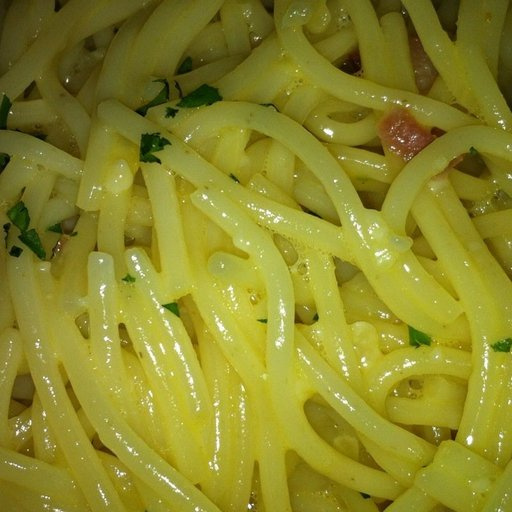

In [ ]:
#@title Analysze data

import random
from PIL import Image
from pathlib import Path

#1.List with all paths to images
#random.seed(12312313)
image_folder=Path("/content/data/food-101/food-101/images")
image_path_list= list(image_folder.glob("*/*.jpg"))
#2.Pick a random image path
random_image_path = random.choice(image_path_list)
#3.Get image class from path name
random_image_class = random_image_path.parent.stem
print()

#4.Open image
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Random image class: {random_image_class} ")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
print(f"Image colour channels: {img.layers}")
img



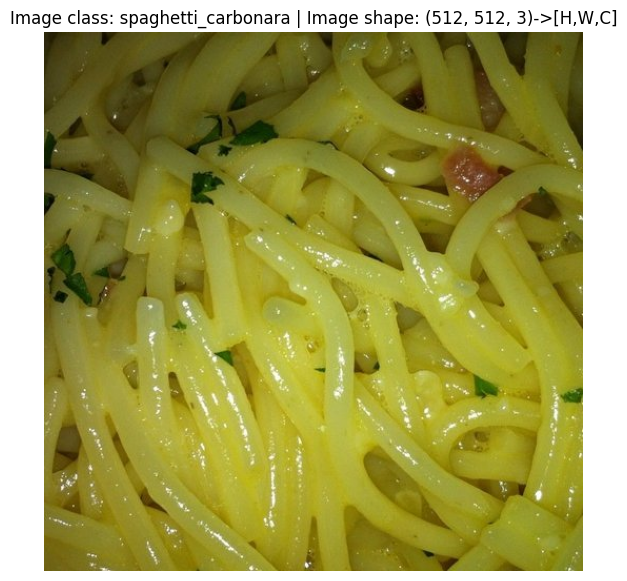

In [ ]:
#@title Visualize with matplotlib
import numpy as np
import matplotlib.pyplot as plt

#Image to array
img_as_array = np.asarray(img)

#Plot the image via matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {random_image_class} | Image shape: {img_as_array.shape}->[H,W,C]")
plt.axis(False)
plt.show()

In [ ]:
#@title Transforming all our data into PyTorch format (next few sections).
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms #transformers important

#1. Data to tensors->torchvision.datasets.ImageFolder via root/dog/xxx.png files stored!
#2. Turn data into torch.utils.Dataset and then into torch.utils.DataLoader


# First: Write transform for image
data_transform = transforms.Compose([
    # This is just for optimization
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #Resize our images to 64*64
    transforms.Resize(size=(SIZE_IMAGE,SIZE_IMAGE)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn the image into a torch.Tensor
    transforms.ToTensor(),
    #RandomErasing-> Randomily errase some pixels of a image!
    transforms.RandomErasing(p=0.15)
])
a=data_transform(img)

"""
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()

])"""
print(f"Image after transform: {a.shape},{a.dtype}")


Image after transform: torch.Size([3, 224, 224]),torch.float32


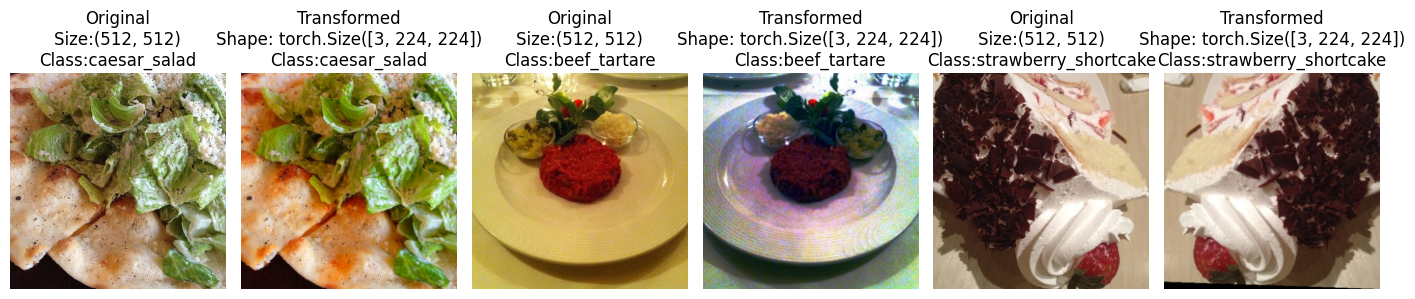

In [ ]:
#@title Visualize transform effect
from PIL import Image
import matplotlib.pyplot as plt
import random
from pathlib import Path

def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Select random images from the database and plot them after data_transform
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    fig, axes = plt.subplots(1, 2 * n, figsize=(14, 5))  # Create a single row for all pairs of images

    for i, image_path in enumerate(random_image_paths):
        with Image.open(image_path) as f:

            transformed_image1 = transform(f)  # change CHW to HWC for matplotlib
            transformed_image = transformed_image1.permute(1, 2, 0).cpu().numpy()
            # Plot original image
            axes[2 * i].imshow(f)
            axes[2 * i].set_title(f"Original\nSize:{f.size}\nClass:{image_path.parent.stem}")
            axes[2 * i].axis(False)

            # Plot transformed image
            axes[2 * i + 1].imshow(transformed_image)
            axes[2 * i + 1].set_title(f"Transformed\nShape: {transformed_image1.shape}\nClass:{image_path.parent.stem}")
            axes[2 * i + 1].axis("off")

            # Add class information as a common title for the entire row

    # Adjust layout for better spacing
    plt.tight_layout()

    plt.show()

# Example usage:
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=None)


Image tensor:
tensor([[[0.7412, 0.7490, 0.6784,  ..., 0.7451, 0.7098, 0.7255],
         [0.7804, 0.7647, 0.6706,  ..., 0.6745, 0.6706, 0.6667],
         [0.7608, 0.7569, 0.7059,  ..., 0.6510, 0.6706, 0.6549],
         ...,
         [0.4353, 0.4549, 0.4902,  ..., 0.6980, 0.6824, 0.6745],
         [0.3529, 0.3569, 0.4235,  ..., 0.7922, 0.7725, 0.7725],
         [0.3490, 0.3373, 0.3451,  ..., 0.7765, 0.7725, 0.7686]],

        [[0.7804, 0.7922, 0.7294,  ..., 0.6196, 0.5882, 0.6039],
         [0.8275, 0.8118, 0.7176,  ..., 0.5569, 0.5529, 0.5490],
         [0.8157, 0.8118, 0.7451,  ..., 0.5373, 0.5608, 0.5451],
         ...,
         [0.4000, 0.4235, 0.4588,  ..., 0.6039, 0.5961, 0.5922],
         [0.3137, 0.3216, 0.3922,  ..., 0.7059, 0.6863, 0.6863],
         [0.3098, 0.2980, 0.3098,  ..., 0.6980, 0.6980, 0.6941]],

        [[0.7843, 0.7961, 0.7333,  ..., 0.5529, 0.5255, 0.5451],
         [0.8314, 0.8157, 0.7098,  ..., 0.4667, 0.4667, 0.4667],
         [0.8157, 0.8039, 0.7255,  ..., 0.43

Dataset ImageFolder
    Number of datapoints: 101000
    Root location: /content/data/food-101/food-101/images
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               RandomErasing(p=0.15, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
           )

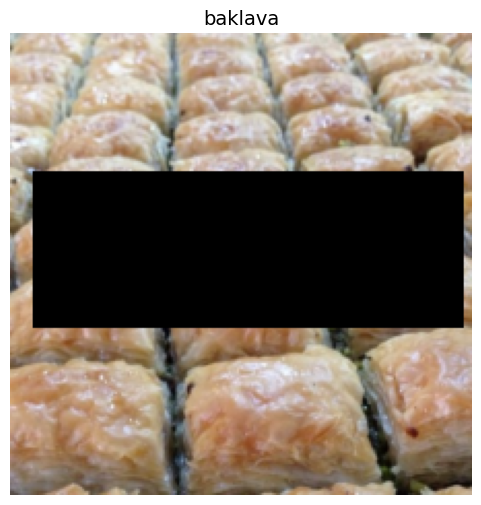

In [ ]:
#@title Option 1: Load image using ImageFolder
from torchvision import datasets
data_path=Path("/content/data/food-101/food-101/images")
data = datasets.ImageFolder(root=data_path,
                            transform=data_transform, #Transform data
                            target_transform=None)  #Transform label
x=np.random.randint(0,10000)
class_names=data.classes
img, label = data[x] #data and associated label
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Image label: {class_names[label]}")
img_permute = img.permute(1,2,0)
plt.figure(figsize=(6,6))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)
data

In [ ]:
#@title Split data from ImageFolder Dataset using random_split
train_data,test_data = torch.utils.data.random_split(data,[1-TRAIN_TEST_RATIO, TRAIN_TEST_RATIO])

In [ ]:
#@title Set up DataLoader
import os
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), #Basically, how many CPU calls to do. Best: os.cpu_count()
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(), #Basically, how many CPU calls to do. Best: os.cpu_count()
                              shuffle=False)
img,label = next(iter(train_dataloader))
print(f"Image batch shape:{img.shape} -> [batch_size,color_channels,height,width]")
print(f"Label shape:{label.shape}")

Image batch shape:torch.Size([64, 3, 224, 224]) -> [batch_size,color_channels,height,width]
Label shape:torch.Size([64])


In [ ]:
#@title Model
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
class FoodClassifier(nn.Module):
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape
               ):
    super().__init__()
     #General fomula for having save output as input: O=(I-F+2P)/S+1
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, #The channels of the image
          out_channels=hidden_units,
          kernel_size=5,
          stride=1,
          padding=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
          out_channels=hidden_units,
          kernel_size=5,
          stride=1,
          padding=2),
        nn.ReLU(),
        #Max pooling 2 basicallyy reduces our height/width shape by half
        nn.MaxPool2d(kernel_size=2,
                     stride=2))
     #General fomula for having save output as input: O=(I-F+2P)/S+1
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
          out_channels=hidden_units,
          kernel_size=5,
          stride=1,
          padding=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
          out_channels=hidden_units,
          kernel_size=5,
          stride=1,
          padding=2),
        nn.ReLU(),
        #Max pooling 2 basicallyy reduces our height/width shape by half
        nn.MaxPool2d(kernel_size=2,
                     stride=2))


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=int(SIZE_IMAGE/4)**2*hidden_units,out_features=output_shape))

    self.layers = nn.Sequential(self.conv_block_1,self.conv_block_2,self.classifier)

  def forward(self,x):
    return self.layers(x)

model_1 = FoodClassifier(input_shape=3,hidden_units=HIDDEN_UNITS,output_shape=len(data.classes)).to(device)


In [ ]:
#@title Nota: Para datos individuales tienes que meterle delante x.unsqueeze(dim=0). Para conjuntos de datos no!
x=train_dataloader.dataset[0][0].to(device)
x.shape
model_1(x.unsqueeze(dim=0)).shape

torch.Size([1, 101])

# Test Model

In [ ]:
#@title Load Previously Trained Model
# To load in a saved state_dcit we have to instantiate a new instance of our model class!
MODEL_PATH = Path("drive/MyDrive/Models")
COURSE_PATH = MODEL_PATH / "Course"
MODEL_NAME = "food_classifier.pth"
MODEL_SAVE_PATH = COURSE_PATH / MODEL_NAME
model_1 = FoodClassifier(input_shape=3,hidden_units=HIDDEN_UNITS,output_shape=len(data.classes)).to(device)

#Load the saved state_dict of model_0, this will update the new isntance with updated parameters!
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
#@title Test Model
%%time

def multiclass_classification_training(model,train_dataloader,test_dataloader,learning_rate,out_shape=10,epochs=2,batches=0):
  # Set up metrics
  from tqdm.auto import tqdm
  import torch
  from torch import nn
  from google.colab import drive
  drive.mount('drive/')
  import os
  from pathlib import Path
  #set loss
  loss_fn = nn.CrossEntropyLoss()
  #set optimizer
  optimizer = torch.optim.SGD(params=model.parameters(),
                              lr=learning_rate)
  # proporcion of correct predictions
  accuracy_fn = torchmetrics.Accuracy(task="multiclass",num_classes=out_shape).to(device)
  # proporcion of predicted positives that are actually positives:  "Out of all the instances the model classified as positive, how many were truly positive?"
  precision_fn = torchmetrics.Precision(task="multiclass",num_classes=out_shape).to(device)
  # proporcion of actual positives that are correctly predicted: "Out of all the truly positive instances in the data, how many did the model correctly identify?
  recall_fn = torchmetrics.Recall(task="multiclass",num_classes=out_shape).to(device)
  # f1: Combines precision and accuracy. Closer to 1 is better
  f1_fn = torchmetrics.F1Score(task="multiclass",num_classes=out_shape).to(device)

  #@title Test Model
  # Set seeds
  torch.manual_seed(44)
  torch.cuda.manual_seed(44)


  # Loop through epochs

  for epoch in tqdm(range(epochs)):
      print(f"Epoch {epoch+1}:\n-----------------------------")
      ### Training
      model_1.train()

      # Initialize metrics for training data
      train_loss, train_accuracy, train_precision, train_recall, train_f1 = 0, 0, 0, 0, 0

      # Loop through training batches
      for batch, (X, y) in enumerate(train_dataloader):
          model_1.train()
          X=X.to(device)
          y=y.to(device)
          # 1. Forward Pass
          y_logits = model_1(X)
          y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
          # 2. Loss and metrics for batched data
          loss = loss_fn(y_logits, y)
          train_loss += loss

          accuracy = accuracy_fn(y_preds, y) * 100
          train_accuracy += accuracy

          precision = precision_fn(y_preds, y) * 100
          train_precision += precision

          recall = recall_fn(y_preds, y) * 100
          train_recall += recall

          f1 = f1_fn(y_preds, y)
          train_f1 += f1
          batches+=1
          # 3. Optimizer zero grad
          optimizer.zero_grad()

          # 4. Loss backward, i.e., backpropagation = calculate gradient
          loss.backward()

          # 5. Optimizer step
          optimizer.step()

          # Print some output
          if batch % (len(train_dataloader)/3)== 0 or batch+1==len(train_dataloader):
              print(f"Looked at {(batch+1) * len(X)}/{len(train_dataloader.dataset)} samples")

      # Average metrics per epoch
      train_loss = train_loss/len(train_dataloader)
      train_accuracy = train_accuracy/len(train_dataloader)
      train_precision = train_precision/len(train_dataloader)
      train_recall = train_recall/len(train_dataloader)
      train_f1 = train_f1/len(train_dataloader)

      ### Testing
      test_loss, test_accuracy, test_precision, test_recall, test_f1 = 0, 0, 0, 0, 0
      model_1.eval()

      with torch.inference_mode():
          for X, y in test_dataloader:
              X=X.to(device)
              y=y.to(device)
              # 1. Forward pass
              y_logits_test = model_1(X)
              y_preds_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)

              # 2. Calculate metrics for the test
              loss_t = loss_fn(y_logits_test, y)
              test_loss += loss_t

              # Metrics by batch
              accuracy_t = accuracy_fn(y_preds_test, y) * 100
              test_accuracy += accuracy_t

              precision_t = accuracy_fn(y_preds_test, y) * 100
              test_precision += precision_t

              recall_t = recall_fn(y_preds_test, y) * 100
              test_recall += recall_t

              f1_t = f1_fn(y_preds_test, y)
              test_f1 += f1_t
      # Average metrics per epoch
      test_loss = test_loss/len(test_dataloader)
      test_accuracy = test_accuracy/len(test_dataloader)
      test_precision = test_precision/len(test_dataloader)
      test_recall = test_recall/len(test_dataloader)
      test_f1 = test_f1/len(test_dataloader)
      print(f"| Loss: {train_loss:.5f}, Acc: {train_accuracy:.2f}%, Pre: {train_precision:.2f}%, Recall: {train_recall:.2f}%, F1: {train_f1:.4}")
      print(f"| TestLoss: {test_loss:.5f}, TestAcc: {test_accuracy:.2f}%, TestPre: {test_precision:.2f}%, TestRecall: {test_recall:.2f}%, TestF1: {test_f1:.4}")
      print(f"| Number of executed batches of size {train_dataloader.batch_size}: {batches}")
      print(f"--------------------------------------------------------------------------------------------------------")

      if epoch % 1 ==0 or epoch+1==epochs:
        # 1. Create models directory
        MODEL_PATH = Path("drive/MyDrive/Models")
        MODEL_PATH.mkdir(parents=True, exist_ok=True)

        COURSE_PATH = MODEL_PATH / "Course"
        COURSE_PATH.mkdir(parents=True, exist_ok=True)

        # 2. Create model save path
        MODEL_NAME = "food_classifier.pth"
        MODEL_SAVE_PATH = COURSE_PATH / MODEL_NAME

        # 3. Check if the model with the same name exists, and delete it if it does
        existing_model_path = COURSE_PATH / MODEL_NAME
        if existing_model_path.exists():
            print(f"Deleting existing model at: {existing_model_path}")
            os.remove(existing_model_path)

        # 4. Save the model state dict()
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

multiclass_classification_training(model=model_1,train_dataloader=train_dataloader,test_dataloader=test_dataloader,learning_rate=LEARNING_RATE,out_shape=len(data.classes),epochs=EPOCHS)


Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
-----------------------------
Looked at 64/80800 samples
Looked at 27008/80800 samples
Looked at 53952/80800 samples
Looked at 40416/80800 samples
| Loss: 4.61323, Acc: 1.05%, Pre: 1.05%, Recall: 1.05%, F1: 0.01054
| TestLoss: 4.61605, TestAcc: 0.91%, TestPre: 0.91%, TestRecall: 0.91%, TestF1: 0.009098
| Number of executed batches of size 64: 1263
--------------------------------------------------------------------------------------------------------
Deleting existing model at: drive/MyDrive/Models/Course/food_classifier.pth
Saving model to: drive/MyDrive/Models/Course/food_classifier.pth
Epoch 2:
-----------------------------
Looked at 64/80800 samples
Looked at 27008/80800 samples
Looked at 53952/80800 samples
Looked at 40416/80800 samples
| Loss: 4.61571, Acc: 0.95%, Pre: 0.95%, Recall: 0.95%, F1: 0.009452
| TestLoss: 4.61630, TestAcc: 0.83%, TestPre: 0.83%, TestRecall: 0.83%, TestF1: 0.008307
| Number of executed batches of size 64: 2526
-----------------------------------

KeyboardInterrupt: 

In [ ]:
#@title Prediction VS Reality with numbers dataset

from IPython.display import display, HTML, clear_output
import io
from PIL import Image
import ipywidgets as widgets
import numpy as np
import torch

# Initialize image_array_list as an empty list globally
image_array_list = []
images=[]
data_transform = transforms.Compose([

    transforms.Resize(size=(SIZE_IMAGE,SIZE_IMAGE)),

    transforms.ToTensor(),

])
# Function to handle the uploaded images and display them
def on_upload_change(change):
    global image_array_list  # Declare image_array_list as a global variable
    clear_output(wait=True)
    uploaded_files = upload_button.value
    if uploaded_files:
        # Iterate through the uploaded files
        for file_name, file_info in uploaded_files.items():
            image = Image.open(io.BytesIO(file_info['content']))
            # Convert the image to a NumPy array
            image_array2=np.array(image)
            images.append(image_array2)
            image_array = data_transform(image).to(device)
            image_array_list.append(image_array)
            # Display the image
    else:
        print("No files uploaded.")

# Create a file upload button
upload_button = widgets.FileUpload(description="Upload Images", accept=".jpg,.jpeg,.png", multiple=True)
upload_button.observe(on_upload_change, names='value')

# Display the file upload button
display(upload_button)

# Create a button for comparison
compare_button = widgets.Button(description="Compare Images")

# Function to handle the comparison
def on_compare_button_click(b):
    clear_output(wait=True)
    print("Reality:")
    # Display all uploaded images
    num_images = len(image_array_list)
    if num_images == 1:
        # Handle the case of a single image separately
        plt.figure(figsize=(1/2, 1/2))
        plt.imshow(image_array_list[0], cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        # Display all uploaded images side by side
        figsizes=[(2,2)]*len(image_array_list)
        fig, axes = plt.subplots(1, num_images, figsize=(sum(figsizes[i][0] for i in range(num_images)), max(figsizes[i][1] for i in range(num_images))))

        for i, image in enumerate(images):
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')

    plt.show()
    # Perform predictions for each image
    print("\nPrediction:")
    predictions=[]
    for image_array in image_array_list:
        image_array_tensor = torch.Tensor(image_array).unsqueeze(dim=0).type(torch.float).to(device)
        with torch.inference_mode():
            prediction_logits = model_1(image_array_tensor)
        prediction_probs = torch.softmax(prediction_logits, dim=1)
        prediction_pred = prediction_probs.argmax().item()
        label=data.classes[prediction_pred]
        predictions.append(label)
    print(f"{predictions}")

# Assign the function to the button click event
compare_button.on_click(on_compare_button_click)

# Display the compare button
display(compare_button)


NameError: name 'transforms' is not defined

In [ ]:
from google.colab import drive
drive.mount('drive/')
import os
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("drive/MyDrive/Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

COURSE_PATH = MODEL_PATH / "Course"
COURSE_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "food_classifier.pth"
MODEL_SAVE_PATH = COURSE_PATH / MODEL_NAME

# 3. Check if the model with the same name exists, and delete it if it does
existing_model_path = COURSE_PATH / MODEL_NAME
if existing_model_path.exists():
    print(f"Deleting existing model at: {existing_model_path}")
    os.remove(existing_model_path)

# 4. Save the model state dict()
print(f"Saving model to: {MODEL_SAVE_PATH}")
#torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)


Mounted at drive/
Saving model to: drive/MyDrive/Models/Course/food_classifier.pth


In [ ]:
data.classes